In [1]:
%pylab inline
img_rows, img_cols = 28, 28

arc = load('mnist.npz')

x_train = arc['arr_0']
y_train = arc['arr_1']
x_test  = arc['arr_2']
y_test  = arc['arr_3']

print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

Populating the interactive namespace from numpy and matplotlib
(60000, 28, 28) (60000,)
(10000, 28, 28) (10000,)


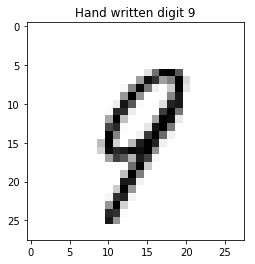

In [2]:
def show(N):
    imshow(x_train[N], cmap='gray_r')
    _ = title('Hand written digit '+str(y_train[N]))
    
show(22)

In [3]:
## ASSIGNMENT 1

## define d_infty
def _Dinfty(a,b):
    return abs(a-b).max()

## define d_one
def _D1(a,b):
    return abs(a-b).sum()

## define d_two
def _D2(a,b):
    return sqrt(square(a-b).sum())

In [4]:
## ASSIGNMENT 2

## this is a slow version of my_func
## which I use to compare the time gain
## w.r.t. the optimized version
## I expect time reduction by half when optimized
def my_func_slow(N,dist):
    X=x_train[:N]
    ret = zeros((N,N))
    for i in range(N):
        ret[i]= [ dist(X[i],B) for B in X ]
    return ret

## this is the optimised version
def my_func(N,dist):
    X=x_train[:N]
    ret = zeros((N,N))
    for i in range(N):
        for j in range(i,N):
            ret[i][j]= dist(X[i],X[j])
    return ret+ret.T

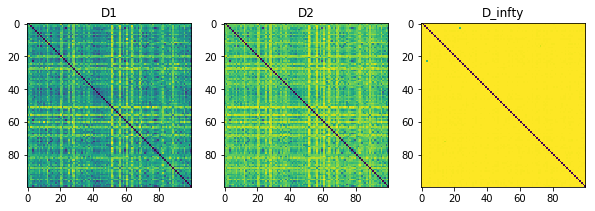

In [5]:
## ASSIGNMENT 3

import matplotlib.pyplot as plt

methods = [_D1,_D2,_Dinfty]
names = {_D1:'D1',_D2:'D2',_Dinfty:'D_infty'}
fig, axs = plt.subplots(1,3,figsize=(10,6))
for ax, method in zip(axs, methods):
    ax.imshow(my_func(100,method),cmap='viridis')
    ax.set_title(names[method].capitalize())
plt.show()

In [6]:
## to measure time
import time

class Timer():
    def __enter__(self):
        self._t0 = time.perf_counter()
    
    def __exit__(self,type,value,traceback):
        self._t1 = time.perf_counter()
        print("Time spent: [%0.8f] secs" % (self._t1-self._t0))
    
with Timer():
    time.sleep(2)

Time spent: [2.00214594] secs


In [7]:
## ASSIGNMENT 4 and 5
## precompute heavy part of the computation

N = 1600
distances = [_D1,_D2,_Dinfty]

## 

with Timer():
    M1 = my_func(N,_D1)
    M2 = my_func(N,_D2)
    M3 = my_func(N,_Dinfty)
    methods = [M1,M2,M3]

Time spent: [21.05417594] secs


In [8]:
## Uncomment these lines if you want to check
## my_func optimization
#with Timer():
 #   methods_slow = []
  #  for dist in distances:
   #     methods_slow.append(my_func_slow(N,dist))

In [9]:
from pprint import pprint
import random

dims = [100,200,400,800,1600]

def efficiency():
    errors = []
    ## computation of the relative errors
    for num in dims:
        loc_errors=[]
        for matrix in methods:
            error_counter = 0.
            for i in range(num):
                M = matrix[i:i+1][0][:num]
                MM = delete(M,i)
                arg = argmin(MM) + int(argmin(MM)>=i)
                digit = y_train[arg]
                if y_train[i] != digit:
                    error_counter +=1
            loc_errors.append(error_counter*100/num)
        errors.append(loc_errors)
    #pprint(errors)
    for k in range(size(distances)):
        plt.plot(dims,[errors[i][k] for i in range(size(dims)) ],label=names[distances[k]])
    plt.legend()
    plt.xlabel('slice dimesnion')
    plt.ylabel('percentage error')
    plt.title('Compare different norms')
    plt.show()
    return errors


def efficiency2():
    errors = []
    ## computation of the relative errors
    for num in dims:
        loc_errors=[]
        for matrix in methods:
            error_counter = 0.
            for i in range(num):
                M = matrix[i:i+1][0][:num]
                MM = delete(M,i)
                indices = where(MM==min(MM))[0]
                digits = [ y_train[j+int(j>=i)] for j in indices ]
                #secure_random = random.SystemRandom()
                #digit = secure_random.choice(digits)
                digit = bincount(digits).argmax()
                #if y_train[i] not in digits:
                if y_train[i] != digit:
                    error_counter +=1
            loc_errors.append(error_counter*100/num)
        errors.append(loc_errors)
    #pprint(errors)
    for k in range(size(distances)):
        plt.plot(dims,[errors[i][k] for i in range(size(dims)) ],label=names[distances[k]])
    plt.legend()
    plt.xlabel('slice dimesnion')
    plt.ylabel('percentage error')
    plt.title('Compare different norms but with Dinfty modified')
    plt.show()
    return errors

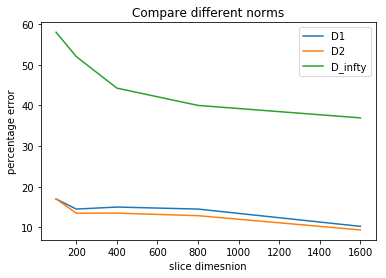

[[17.0, 17.0, 58.0],
 [14.5, 13.5, 52.0],
 [15.0, 13.5, 44.25],
 [14.5, 12.875, 40.0],
 [10.25, 9.375, 36.9375]]


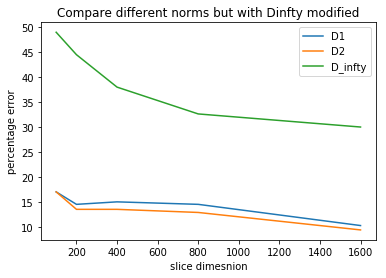

In [10]:
errors = efficiency()
pprint(errors)
errors2 = efficiency2()

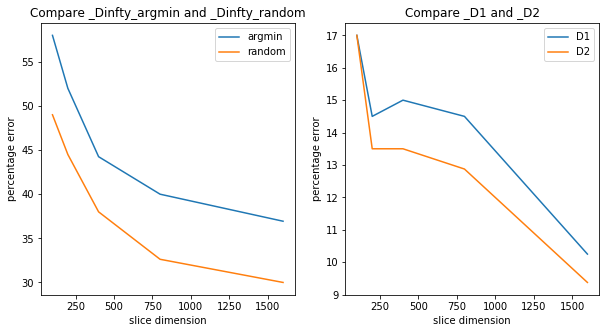

In [11]:
## compare performance of _Dinfty with two different error estimators
## and focus on the difference between D1 and D2
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(10,5))

line1, = ax1.plot(dims,[errors[i][2] for i in range(size(dims))],label='argmin')
line2, = ax1.plot(dims,[errors2[i][2] for i in range(size(dims))],label='random')
ax1.legend()
ax1.set_title('Compare _Dinfty_argmin and _Dinfty_random')

line3, = ax2.plot(dims,[errors[i][0] for i in range(size(dims))],label='D1')
line4, = ax2.plot(dims,[errors[i][1] for i in range(size(dims))],label='D2')
ax2.legend()
ax2.set_title('Compare _D1 and _D2')

ax1.set_xlabel('slice dimension')
ax1.set_ylabel('percentage error')
ax2.set_xlabel('slice dimension')
ax2.set_ylabel('percentage error')

plt.show()

In [12]:
## define the classify function for later usage
## uncomment the following line or set X before calling
def classify(z,dist,X):
    all_distances = [dist(z,x) for x in X]
    digit = y_train[argmin(all_distances)]
    
    return digit

(0, 6)

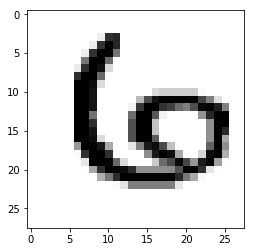

In [13]:
## Example
## scooped!
p = 54
_=imshow(x_test[p], cmap='gray_r')
classify(x_test[p],_D2,x_train[:1000]), y_test[p]

In [14]:
## test x_test angainst y_test with the distance D2
## notice that, for consistency, if you test x_train vs y_train
## you should get 0.000 errors with any norm: try it!

def my_test(X,Y,dist,Z):
    errors = 0.
    test_range = 1000
    Tx = X[:test_range]
    Ty = Y[:test_range]
    for i in range(test_range):
        candidate = classify(Tx[i],dist,Z)
        if candidate != Ty[i]:
            errors += 1
    errors = errors*100/test_range
    print("percentage error: %0.5f" % errors)

In [15]:
with Timer():
    my_test(x_test,y_test,_D2,x_train[:1000])

percentage error: 17.20000
Time spent: [6.33023704] secs


In [16]:
## ASSIGNMENT 6
from scipy.integrate import simps as quad

## given the typical structure of our figures, namely
## 1. that points are equally spaced in x and y direction
## 2. that boundary points are zero
## the integral by trapezoids is equal to the sum of the matrix!
## therefore I implement my_trapz, which is extremely fast :)

def my_quad(obj):
    return obj.sum()

In [17]:
## compute all the integrals
S = 1600 
X = x_train[:S]
Y = y_train[:S]

#integrals = [ quad(quad(X[i])) for i in range(1600) ]
integrals = [ my_quad(X[i]) for i in range(S) ]

## compute the new set of train ...
z_train = [X[i]/integrals[i] for i in range(S)]

## and their gradients ...
gradients = [gradient(z_train[i]) for i in range(S)]

In [18]:
## function for gradient norms
def _Dsqr(a,b):
    return square(a[0]-b[0])+square(a[1]-b[1])

## define new distances

## notice that I do not do the sqrt in H1
def _Dh1(i,j):
    integrand = square(z_train[i]-z_train[j])+_Dsqr(gradients[i],gradients[j])
    res = my_quad(integrand)
    return res

## this is my_distance
## which is just D1, but with z_train instead of x_train ;)
def my_dist(i,j):
    integrand = abs(z_train[i]-z_train[j])
    res = my_quad(integrand)
    return res

## this is for initializing the distance matrix
def my_func2(N,dist):
    ret = zeros((N,N))
    for i in range(N):
        for j in range(i,N):
            ret[i][j] = dist(i,j)
    return ret+ret.T

In [19]:
with Timer():
    M4 = my_func2(S,_Dh1)
with Timer():
    M5 = my_func2(S,my_dist)

Time spent: [14.58404016] secs
Time spent: [6.53662781] secs


In [20]:
## update data for efficiency comparison
methods = [M2,M4,M5]
distances=[_D2,_Dh1,my_dist]
names[_Dh1]='H1'
names[my_dist]='my_dist'

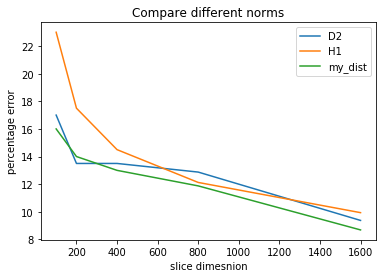

[[17.0, 23.0, 16.0],
 [13.5, 17.5, 14.0],
 [13.5, 14.5, 13.0],
 [12.875, 12.125, 11.875],
 [9.375, 9.9375, 8.6875]]


In [21]:
errors3=efficiency()
pprint(errors3)

In [22]:
## I create an environment to test
## x_test with the new distances

## new classifier
def _DH1(T,G,j):
    integrand = square(z_train[j]-T)+_Dsqr(gradients[j],G)
    res = my_quad(integrand)
    return res

def my_dist2(T,G,j):
    return abs(T-z_train[j]).sum()
    
def classify2(T,G,dist,z_range):
    all_distances = [dist(T,G,i) for i in range(z_range)]
    digit = y_train[argmin(all_distances)]    
    return digit

def my_test2(X,Y,dist):
    errors = 0.
    test_range = 1000
    Tx = [X[i]/X[i].sum() for i in range(test_range)]
    Gx = [gradient(Tx[i]) for i in range(test_range)]
    Ty = Y[:test_range]
    for i in range(test_range):
        candidate = classify2(Tx[i],Gx[i],dist,1000)
        if candidate != Ty[i]:
            errors += 1
    errors = errors*100/test_range
    print("percentage error: %0.5f" % errors)

In [23]:
with Timer():
    print('with H1: '), my_test2(x_test,y_test,_DH1)
with Timer():
    print('with my_dist: '), my_test2(x_test,y_test,my_dist2)

with H1: 
percentage error: 16.90000
Time spent: [11.15009110] secs
with my_dist: 
percentage error: 16.70000
Time spent: [4.74418872] secs


(0, 6)

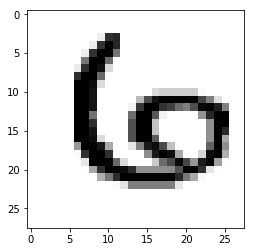

In [24]:
## Example
## scooped!
p = 54
_=imshow(x_test[p], cmap='gray_r')
xt = x_test[p]/x_test[p].sum()
gt = gradient(xt)
classify2(xt,gt,my_dist2,1000), y_test[p]

In [117]:
## ASSIGNMENT 7

## I solve the Laplace equation using Jacobi method
## First I write a function whihc does a single Jacobi iteraion

def Jacobi_1(old,rhs):
    new = zeros((28,28))
    for i in range(1,27):
        for j in range(1,27):
            new[i][j] = 0.25*(old[i-1][j]+old[i+1][j]+old[i][j-1]+old[i][j+1]-rhs[i][j])
    return new

## Define also the discrete Laplacian operator
## which is not explicitely needed, but just in case ...
def Laplacian(obj):
    res = zeros((28,28))
    for i in range(1,27):
        for j in range(1,27):
            res[i][j] = obj[i+1][j]+obj[i-1][j]-4*obj[i][j]+obj[i][j-1]+obj[i][j+1]
    return res

In [166]:
## Let us scrutinize a test case
## we solve the Laplacian Eq. for the RHS == z_train[0]

err = 1
eps = 10**(-4)
RHS = z_train[0]
phi = zeros((28,28))

with Timer():
    while (err > eps):
        psi = Jacobi_1(phi,RHS)
        psi, phi = phi, psi
        err = abs(phi-psi).max()
    print(err)

9.986267202057031e-05
Time spent: [0.31696029] secs


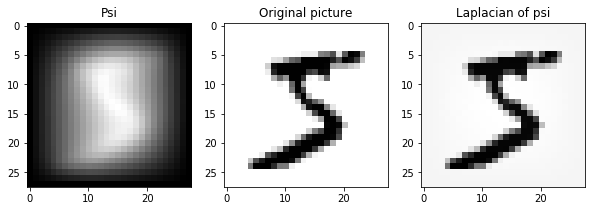

In [167]:
## plot the solution and
## verify the coincidence between
## the Laplacian of psi and original picture

fig, axs = plt.subplots(1,3,figsize=(10,10))
axs[0].imshow(psi,cmap='gray_r')
axs[1].imshow(RHS,cmap='gray_r')
axs[2].imshow(Laplacian(psi),cmap='gray_r')
axs[0].set_title('Psi')
axs[1].set_title('Original picture')
axs[2].set_title('Laplacian of psi')
plt.show()